<a href="https://colab.research.google.com/github/Grachik22/Machine_learning/blob/main/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download umairshahpirzada/birds-20-species-image-classification

birds-20-species-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip birds-20-species-image-classification

Archive:  birds-20-species-image-classification.zip
  inflating: images to predict/1.jpg  
  inflating: images to predict/2.jpg  
  inflating: images to predict/3.jpg  
  inflating: images to predict/4.jpg  
  inflating: images to predict/5.jpg  
  inflating: images to predict/6.jpg  
  inflating: test/ABBOTTS BABBLER/1.jpg  
  inflating: test/ABBOTTS BABBLER/2.jpg  
  inflating: test/ABBOTTS BABBLER/3.jpg  
  inflating: test/ABBOTTS BABBLER/4.jpg  
  inflating: test/ABBOTTS BABBLER/5.jpg  
  inflating: test/ABBOTTS BOOBY/1.jpg  
  inflating: test/ABBOTTS BOOBY/2.jpg  
  inflating: test/ABBOTTS BOOBY/3.jpg  
  inflating: test/ABBOTTS BOOBY/4.jpg  
  inflating: test/ABBOTTS BOOBY/5.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/1.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/2.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/3.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/4.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/5.jpg  
  inflating: test/AFRICAN CROWNED CRANE

In [ ]:
! kaggle competitions download dpl302m-project-1-dog-breed-identification

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.


In [8]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, dataloader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import re
import torch.nn.functional as F
from torch import optim
from torchvision.io import read_image
from torch.utils.data import TensorDataset
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import os
import pandas as pd

In [9]:
torch.cuda.is_available()

True

In [10]:
writer = SummaryWriter()

Первое задание

In [11]:
train_dir = Path('train')
test_dir = Path('test')
train_file_path = sorted(list(train_dir.rglob('*.jpg'))) #пути к обучающей выборке
test_file_path = sorted(list(test_dir.rglob('*.jpg')))   #пути к тренеровочной выборке

len(train_file_path)

3208

In [12]:
#размер тестовой выборки
len(test_file_path)

100

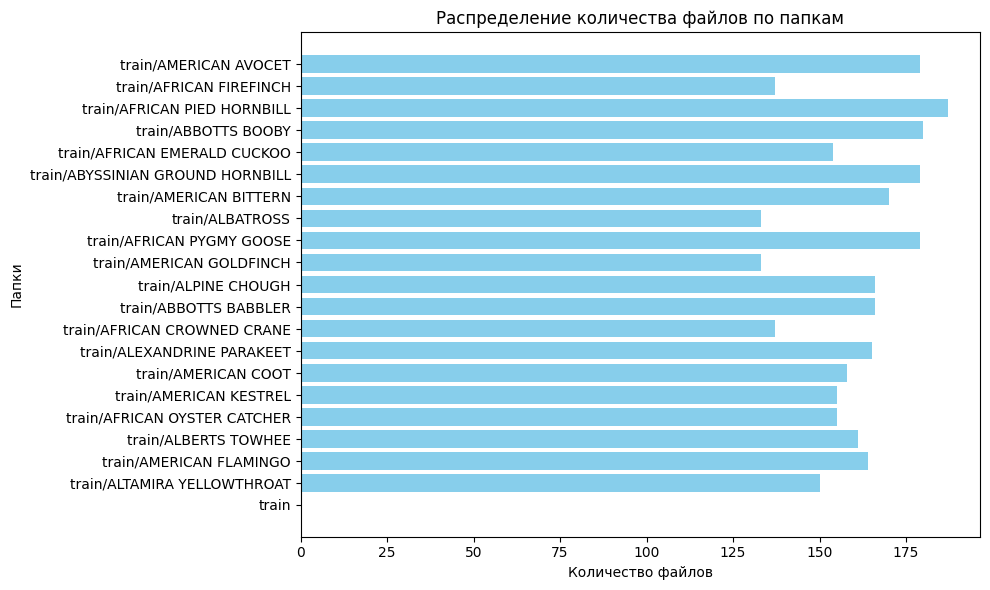

In [13]:
def count_files_in_directory(directory):
    """
    Функция для подсчета количества файлов в каждой папке.
    """
    file_count = {}

    # Рекурсивная функция для обхода всех папок
    def count_files_helper(folder):
        for root, dirs, files in os.walk(folder):
            file_count[root] = len(files)
            for d in dirs:
                count_files_helper(os.path.join(root, d))

    count_files_helper(directory)
    return file_count

def plot_file_distribution(file_count):
    """
    Функция для построения графика распределения количества файлов по папкам.
    """
    folders = list(file_count.keys())
    counts = list(file_count.values())

    plt.figure(figsize=(10, 6))
    plt.barh(folders, counts, color='skyblue')
    plt.xlabel('Количество файлов')
    plt.ylabel('Папки')
    plt.title('Распределение количества файлов по папкам')
    plt.tight_layout()
    plt.show()

directory = 'train'
file_count = count_files_in_directory(directory)
plot_file_distribution(file_count)


In [ ]:
# a = pd.read_csv('birds.csv', usecols=['filepaths', 'labels'])
# a.iloc[1000, 0]

In [ ]:
# class BirdsDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file, usecols=['filepaths', 'labels'])
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [ ]:
# import pandas as pd

class BirdsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, usecols=['filepaths', 'labels'])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)

        return (image, label)


3 задание.  Использование DataLoader для разбиения на батчи:

In [22]:
train_data_dir = 'train'
val_data_dir = 'valid'

In [ ]:
train_dataset = BirdsDataset('birds.csv', '')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = BirdsDataset('birds.csv', '')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_dataset = BirdsDataset('birds.csv', '')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_data_dir, transform=transform)

# Создадим DataLoader для обучения и валидации
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

4 задание.  Обучить модель, состоящую из полносвязных слоёв или обучить модель,
состоящую из сверточных и полносвязных слоев

In [23]:
import torch.optim as optim

In [37]:
class NeuralNet(nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = nn.Conv2d(3, 6, 5)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(6, 16, 5)
    #     self.fc1 = nn.Linear(16 * 5 * 5, 120)
    #     self.fc2 = nn.Linear(120, 84)
    #     self.fc3 = nn.Linear(84, 10)

    # def forward(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = torch.flatten(x, 1) # flatten all dimensions except batch
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x
    def __init__(self, num_classes=20):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 56 * 56, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

    # def forward(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = torch.flatten(x, 1) # flatten all dimensions except batch
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x
    def forward(self,x):

       out = self.layer1(x)
       out = self.layer2(out)
       out = out.view(out.size(0),-1)
       out = self.ReLU(self.fc1(out))
       out = self.fc2(out)
       return out

In [44]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Обучение

In [58]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [59]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [48]:
correct_pred = {classname: 0 for images, classname in train_loader}
total_pred = {classname: 0 for images, classname in train_loader}

In [60]:
# Переведите модель в режим оценки (evaluation mode)
model.eval()

# Получите предсказания для обучающих данных
with torch.no_grad():
    all_predictions = []
    for inputs, labels in val_loader:  # train_loader - ваш DataLoader для обучающих данных
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())

In [74]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


true_labels = [label for _, label in val_loader.dataset]  # Истинные метки
cm = confusion_matrix(true_labels, all_predictions)

In [77]:
# Вычисление метрик
accuracy = accuracy_score(true_labels, all_predictions)
precision = precision_score(true_labels, all_predictions, average='weighted')
recall = recall_score(true_labels, all_predictions, average='weighted')
f1 = f1_score(true_labels, all_predictions, average='weighted')

# Вывод метрик
print(f"(accuracy): {accuracy:.4f}")
print(f" (precision): {precision:.4f}")
print(f" (recall): {recall:.4f}")
print(f" (F1 Score): {f1:.4f}")

(accuracy): 0.5700
 (precision): 0.6390
 (recall): 0.5700
 (F1 Score): 0.5654


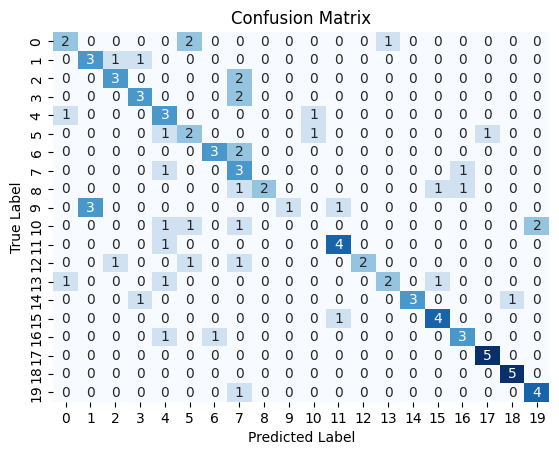

In [62]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [70]:
from sklearn.metrics import roc_curve, auc
# Получите вероятности для тестовых данных
with torch.no_grad():
    all_probs = []
    for inputs, _ in val_loader:  # val_loader - ваш DataLoader для тестовых данных
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs[:, 1].tolist())  # Вероятность принадлежности к классу 1

# Истинные метки (0 или 1) оставляем в виде целых чисел
true_labels = [label for _, label in val_loader.dataset]

# Вычисление ROC-кривой и AUC
fpr, tpr, _ = roc_curve(true_labels, all_probs)
roc_auc = auc(fpr, tpr)

ValueError: multiclass format is not supported

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Обучение на ResNet18

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch [1/2], Train Loss: 0.6150, Train Accuracy: 0.8155, Val Loss: 0.4108, Val Accuracy: 0.8900
Epoch [2/2], Train Loss: 0.2793, Train Accuracy: 0.9137, Val Loss: 0.1936, Val Accuracy: 0.9300


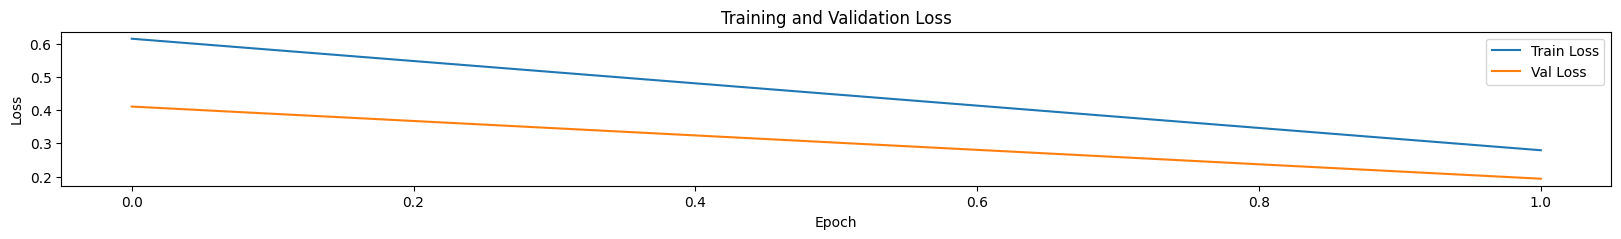

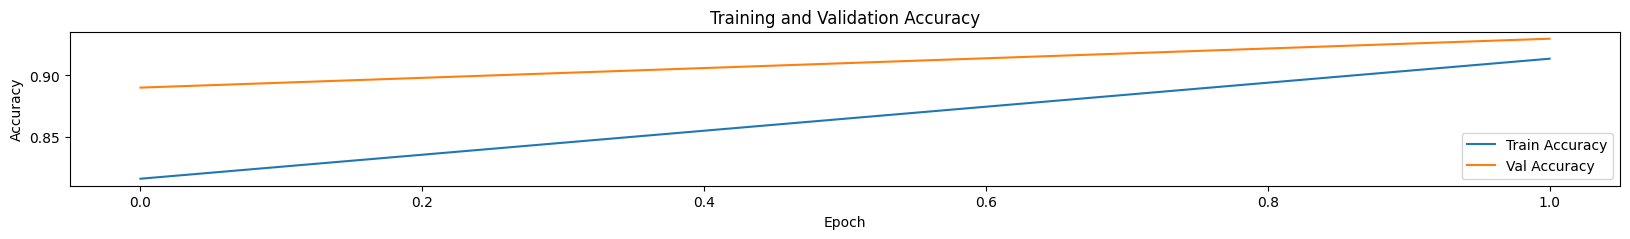

In [16]:
train_data_dir = 'train'
val_data_dir = 'valid'

# Определим преобразования изображений для обучения и валидации
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер входного изображения для ResNet-18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Стандартизация данных
])

# Загрузим данные с помощью ImageFolder
train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_data_dir, transform=transform)

# Создадим DataLoader для обучения и валидации
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Загрузим предварительно обученную модель ResNet-18
model_resnet = models.resnet18(pretrained=True)

# Заменим последний слой (fully connected) на новый, соответствующий нашему набору данных
num_classes = len(train_dataset.classes)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Обучение модели
num_epochs = 2
train_losses = []
val_losses = []
train_accs = []
val_accs = []


for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    model_resnet.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    val_loss = 0.0
    correct_val = 0
    total_val = 0


    model_resnet.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_resnet(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Визуализация графиков потерь и точности
plt.figure(figsize=(20, 2))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

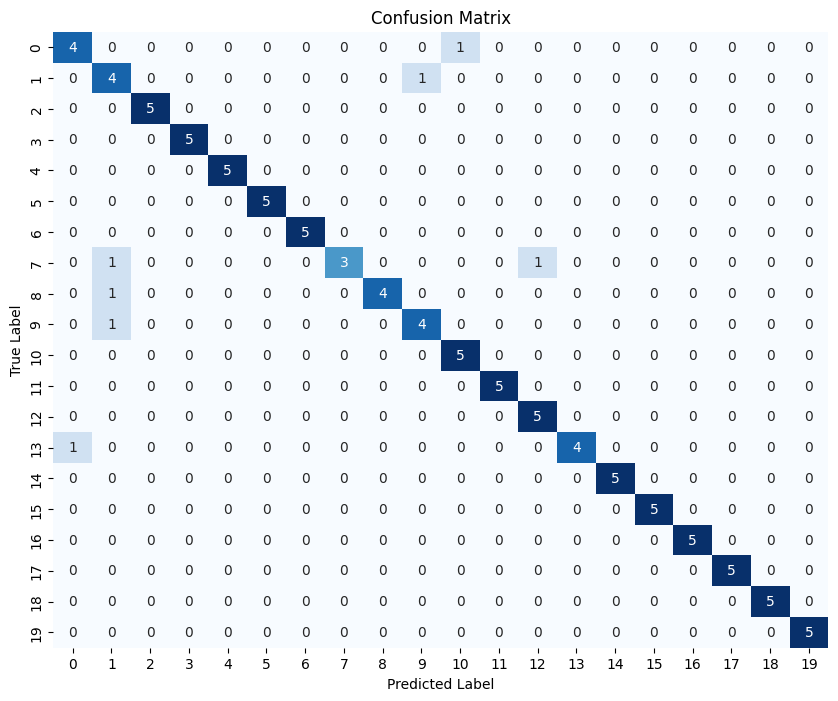

In [18]:
# Создадим список предсказаний и истинных меток для валидационного набора данных
all_preds = []
all_labels = []

# В режиме оценки (eval) вычислим предсказания для каждого мини-батча валидационного набора данных
model_resnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Преобразуем списки в массивы numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Построим матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)

# Визуализируем матрицу ошибок с помощью тепловой карты (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Загрузим данные с помощью ImageFolder
test_dataset = torchvision.datasets.ImageFolder('test', transform=transform)

# Создадим DataLoader для обучения и валидации
# batch_size = 32
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

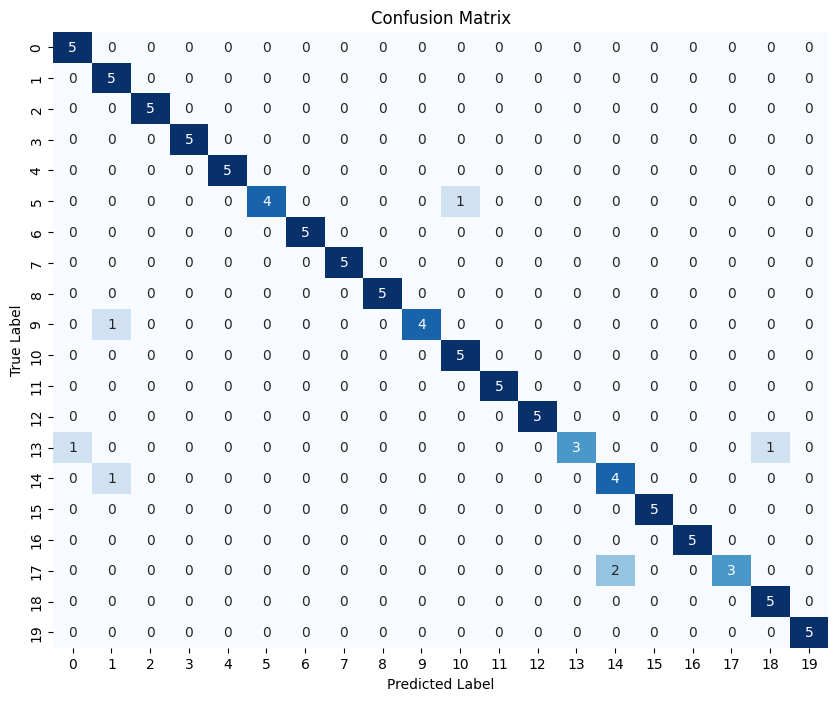

In [20]:
# Создадим список предсказаний и истинных меток для валидационного набора данных
all_preds = []
all_labels = []

# В режиме оценки (eval) вычислим предсказания для каждого мини-батча валидационного набора данных
model_resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Преобразуем списки в массивы numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Построим матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)

# Визуализируем матрицу ошибок с помощью тепловой карты (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [78]:
# Вычисление метрик
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Вывод метрик
print(f"(accuracy): {accuracy:.4f}")
print(f" (precision): {precision:.4f}")
print(f" (recall): {recall:.4f}")
print(f" (F1 Score): {f1:.4f}")


(accuracy): 0.9300
 (precision): 0.9440
 (recall): 0.9300
 (F1 Score): 0.9283
